# Costa Rica Pipeline Notebook
## {Insert info on notebook purpose}

### Project objective:
- {TODO}

#### Notebook sections:
1. Setup
2. English Translations
3. Clean Observational data
4. Extract Medoid and NEM data (provide file of data in case they don't want to run it for hours)
5. Create and Extract Predictor surfaces (pred2)
6. Clean Remote Sensing data
7. Preprocessing
8. Build a predictive model

#### Data sources
- {TODO}

## Section 1: Setup
### Installing software

In [1]:
# !pip install pandas numpy geopandas seaborn scikit-learn tensor folium folium matplotlib mapclassify earthengine-api geemap

### Importing packages

In [2]:
# Geospatial libraries for handling and visualizing geospatial data
from geopandas import GeoDataFrame
from shapely.geometry import Point
import geopandas as gpd
import folium
import geemap
import ee

# general-purpose data manipulation libraries
import pandas as pd
import numpy as np

# data visualization and graphing purposes
import matplotlib.pyplot as plt
import seaborn as sb 


import pprint

### Importing our Dataset

In [3]:
# We are importing the observational data from the ZIP file provided (which contains the shape file) into a GeoDataFrame
gdf = gpd.read_file('Data/Clasification_Plots.zip')

# These display information about the GeoDataFrame to confirm the contains are what we expected
display(gdf.crs)
display(gdf.columns)

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Index(['Source.Nam', 'plotid', 'sampleid', 'lon', 'lat', 'sample_geo', 'Uso',
       'Cobertura', 'Vegetacion', 'Herbaceas', 'Pasto_Arb', 'Cultivo',
       'Humedal', 'Terreno', 'Agua', 'Otra_clase', 'SAF', 'Cambios15_',
       'Gana_Perdi', 'geometry'],
      dtype='object')

In [4]:
# Extra analysis, remove later
unique_values = {'Otra_clase': gdf['Otra_clase'].unique().tolist()}
display(unique_values)

unique_values = {'Cobertura': gdf['Cobertura'].unique().tolist()}
display(unique_values)

{'Otra_clase': [None,
  'Edificado / Desarrollado',
  'Suelo desnudo',
  'Nubes',
  'Sombra de nubes',
  'Paramo',
  'Playas y arenales']}

{'Cobertura': ['Vegetacion',
  'Sin vegetacion',
  'Agua',
  'Sin informacion',
  'Nubes y sombras',
  None]}

## Section 2: English Translations
### {subheading}

In [5]:
# Insert code here for Section 2
k_clms = ['plotid','sampleid','Uso','Cobertura','Vegetacion','Herbaceas', 'Pasto_Arb', 'Cultivo','Humedal', 'Terreno','Agua','Otra_clase','SAF','Cambios15_','Gana_Perdi','geometry']
gdf_s=gdf[k_clms]
# gdf_s


# new column names
english_translations_predictors = {
    'Uso': 'Use',
    'Cobertura': 'CoverType',
    'Vegetacion': 'Vegetations',
    'Herbaceas': 'Herbaceous',
    'Pasto_Arb': 'GrasslandShrub',
    'Cultivo': 'CropsType',
    'Humedal': 'WetlandArea',
    'Terreno': 'LandType',
    'Agua': 'WaterBodyType',
    'Otra_clase': 'OtherClass',
    'SAF': 'SAF',  
    'Cambios15_': 'Changes_15',
    'Gana_Perdi': 'Gain_Loss',
}

# Create a new GeoDataFrame with selected columns and translations
gdf_s = gdf[k_clms].copy()  # Creating a new GeoDataFrame
gdf_s.rename(columns=english_translations_predictors, inplace=True)  # Renaming columns
# Save the new GeoDataFrame to gdf_e
gdf_e = gdf_s.copy()

In [6]:
# # verify if everything has been named properly
# gdf_e.head()
# gdf_e.dtypes # each feature is categorical so, we need to further translate the unique values for the geo df

In [7]:
# set display options to show more content
pd.set_option('display.max_colwidth', None)  # Allows full width of content in each column
pd.set_option('display.max_rows', None)      # Show all rows (if there are not too many unique values)

# Now, get and display unique values for each categorical feature
unique_values = gdf_s.select_dtypes(include=['object', 'category']).apply(lambda x: x.unique())

# Display the result
print(unique_values)

Use                 [Bosque, Pastos, Humedal, Otras clases, Agricultura, Plantacion forestal, Sin informacion, None]
CoverType                                 [Vegetacion, Sin vegetacion, Agua, Sin informacion, Nubes y sombras, None]
Vegetations                           [Arboles, Herbaceas, None, Palmas, Arbustos, Otra vegetacion, Saran, Plastico]
Herbaceous                                                              [None, Gramineas, Otras Herbaceas, Musaceas]
GrasslandShrub                 [None, Pastos mezclados (70-90%), Pastos Puros (90-100%), Pastos Combinados (50-70%)]
CropsType                              [None, Pina, Otro, Arroz, Citricos, Cana, Palma, Banano, Melon, Sandia, Cafe]
WetlandArea                                 [None, Pantano (Palustre), Cuerpos de agua, Yolillal, Salinera, Manglar]
LandType                                               [None, Otras superficies, Terreno descubierto, Suelo desnudo]
WaterBodyType                                                   

### Spanish to English Translation for each Feature unique value in the `gdf_s`
Renanming each predictor according to their respective English translation

In [8]:
# Translation dictionaries for each categorical predictor
translation_dicts = {
    'Use': { # num of missing values: 216
        'Bosque': 'Forest',
        'Pastos': 'Grasslands',
        'Humedal': 'Wetlands',
        'Otras clases': 'Other classes',
        'Agricultura': 'Agriculture',
        'Plantacion forestal': 'Forest plantation',
        'Sin informacion': 'No information',
        'None': 'None'
    },
    'CoverType': { # num of missing values: 216
        'Vegetacion': 'Vegetation',
        'Sin vegetacion': 'No vegetation',
        'Agua': 'Water',
        'Sin informacion': 'No information',
        'Nubes y sombras': 'Clouds and shadows',
        'None': 'None'
    },
     'Changes_15': {# num of missing values: 216
        'No se determina': 'Not determined',
        'No': 'No',
        'Si': 'Yes',
        'None': 'None'
    },
    'Vegetations': {
        'Arboles': 'Trees',
        'Herbaceas': 'Herbaceous plants',
        'None': 'None',
        'Palmas': 'Palms',
        'Arbustos': 'Shrubs',
        'Otra vegetacion': 'Other vegetation',
        'Saran': 'Saran (plastic cover)',
        'Plastico': 'Plastic'
    },
    'Herbaceous': {
        'None': 'None',
        'Gramineas': 'Grasses',
        'Otras Herbaceas': 'Other Herbaceous',
        'Musaceas': 'Plantains'
    },
    'GrasslandShrub': {
        'None': 'None',
        'Pastos mezclados (70-90%)': 'Mixed Pasture (70-90%)',
        'Pastos Puros (90-100%)': 'Pure Pasture (90-100%)',
        'Pastos Combinados (50-70%)': 'Combined Pasture (50-70%)'
    },
    'CropsType': { # 10 different crop types 
        'None': 'None',
        'Pina': 'Pineapple',
        'Otro': 'Other',
        'Arroz': 'Rice',
        'Citricos': 'Citrus',
        'Cana': 'Sugarcane',
        'Palma': 'Palm',
        'Banano': 'Banana',
        'Melon': 'Melon',
        'Sandia': 'Watermelon',
        'Cafe': 'Coffee'
    },
     'WaterBodyType': { # 2 types of water bodies
        'None': 'None',
        'Continentales': 'Continental',
        'Mar�timas': 'Marine'
    },
    
    'WetlandArea': { # 5 wetland area types 
        'None': 'None',
        'Pantano (Palustre)': 'Swamp (Marsh)',
        'Cuerpos de agua': 'Water bodies',
        'Yolillal': 'Yolillal_Plants',
        'Salinera': 'Salt marsh',
        'Manglar': 'Mangrove'
    },
    'LandType': { 
        'None': 'None',
        'Otras superficies': 'Other surfaces', # forested areas? 
        'Terreno descubierto': 'Exposed land', #  land degradation (soil is exposed)
        'Suelo desnudo': 'Bare Land' # lacks cover (deforestation, desert)
    },
    'OtherClass': {
        'None': 'None',
        'Edificado / Desarrollado': 'Built/Developed',
        'Suelo desnudo': 'Bare Land',
        'Nubes': 'Clouds',
        'Sombra de nubes': 'Cloud shadow',
        'Paramo': 'Páramo (high-altitude ecosystem)',
        'Playas y arenales': 'Beaches and sandbanks'
    },
    'SAF': {
        'None': 'None',
        'Cultivo Puro (90-100%)': 'Pure crop (90-100%)',
        'Cultivo mezclado (70-90%)': 'Mixed crop (70-90%)',
        'Cultivo Combinado (50-70%)': 'Combined crop (50-70%)'
    },
    'Gain_Loss': {
        'None': 'None',# third category no gain or loss 
        'Perdida de Bosque': 'Forest loss',
        'Ganancia de Bosque': 'Forest gain'
    }
}

# Loop through each column and replace the Spanish values with the English translations
for col, trans_dict in translation_dicts.items():
    gdf_e[col] = gdf_e[col].replace(trans_dict)

In [9]:
# Now the original columns will be replaced with the translated English values
# Display the unique translated values for each column
for col in gdf_e.select_dtypes(include=['object', 'category']).columns:
    print(f"Unique values for {col}:")
    print(gdf_e[col].unique())
    print("\n")

Unique values for Use:
['Forest' 'Grasslands' 'Wetlands' 'Other classes' 'Agriculture'
 'Forest plantation' 'No information' None]


Unique values for CoverType:
['Vegetation' 'No vegetation' 'Water' 'No information'
 'Clouds and shadows' None]


Unique values for Vegetations:
['Trees' 'Herbaceous plants' None 'Palms' 'Shrubs' 'Other vegetation'
 'Saran (plastic cover)' 'Plastic']


Unique values for Herbaceous:
[None 'Grasses' 'Other Herbaceous' 'Plantains']


Unique values for GrasslandShrub:
[None 'Mixed Pasture (70-90%)' 'Pure Pasture (90-100%)'
 'Combined Pasture (50-70%)']


Unique values for CropsType:
[None 'Pineapple' 'Other' 'Rice' 'Citrus' 'Sugarcane' 'Palm' 'Banana'
 'Melon' 'Watermelon' 'Coffee']


Unique values for WetlandArea:
[None 'Swamp (Marsh)' 'Water bodies' 'Yolillal_Plants' 'Salt marsh'
 'Mangrove']


Unique values for LandType:
[None 'Other surfaces' 'Exposed land' 'Bare Land']


Unique values for WaterBodyType:
[None 'Continental' 'Marine']


Unique values for O

### New translated gdf is named 
∴ `gdf_e`

## Section 3: Clean Observational Data

### Heat Matrix (to view the correlation relationship between all of the predictors) 

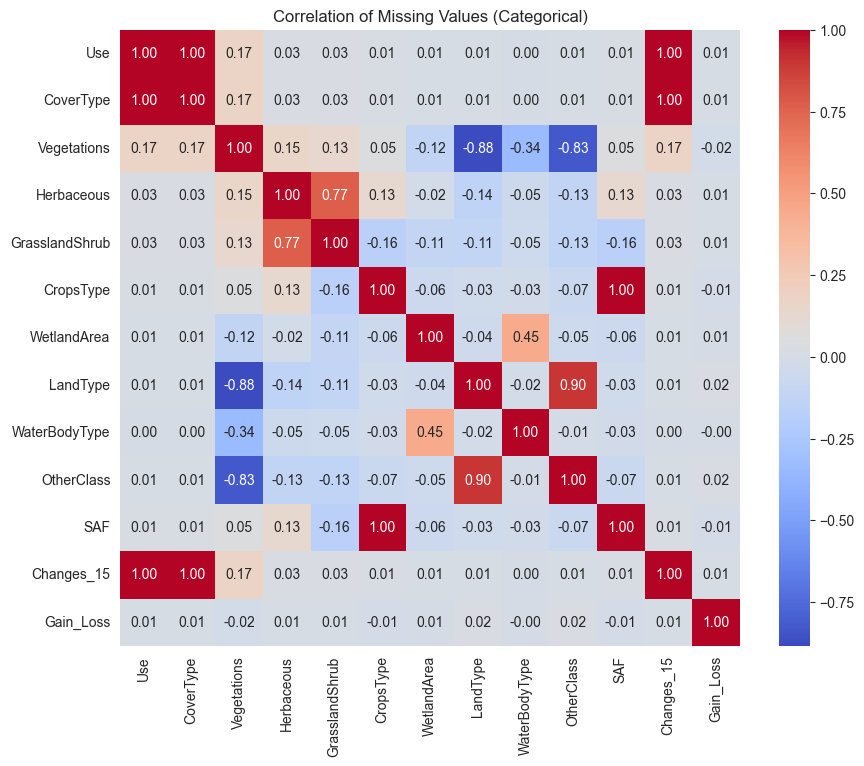

In [10]:
# categorical missingness
categorical_cols = gdf_e.select_dtypes(include=['object']).columns
categorical_missing = gdf_e[categorical_cols].isnull()

# numerical missingness
numerical_cols = gdf_e.select_dtypes(include=['float64', 'int64']).columns
numerical_missing = gdf_e[numerical_cols].isnull()

# Plot for categorical missingness
plt.figure(figsize=(10, 8))
sb.heatmap(categorical_missing.corr(), annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title("Correlation of Missing Values (Categorical)")
plt.show()

### Groups based on some signficance

### Col: Changes_15 
- Vegetations
- CoverType
- Use

In [11]:
# to get unique values of a specific column, for example 'Vegetations'
unique_vegetations = gdf_e['Vegetations'].unique()
print(unique_vegetations)

unique_vegetations = gdf_e['CoverType'].unique()
print(unique_vegetations)

unique_vegetations = gdf_e['Changes_15'].unique()
print(unique_vegetations)

['Trees' 'Herbaceous plants' None 'Palms' 'Shrubs' 'Other vegetation'
 'Saran (plastic cover)' 'Plastic']
['Vegetation' 'No vegetation' 'Water' 'No information'
 'Clouds and shadows' None]
['Not determined' 'No' 'Yes' None]


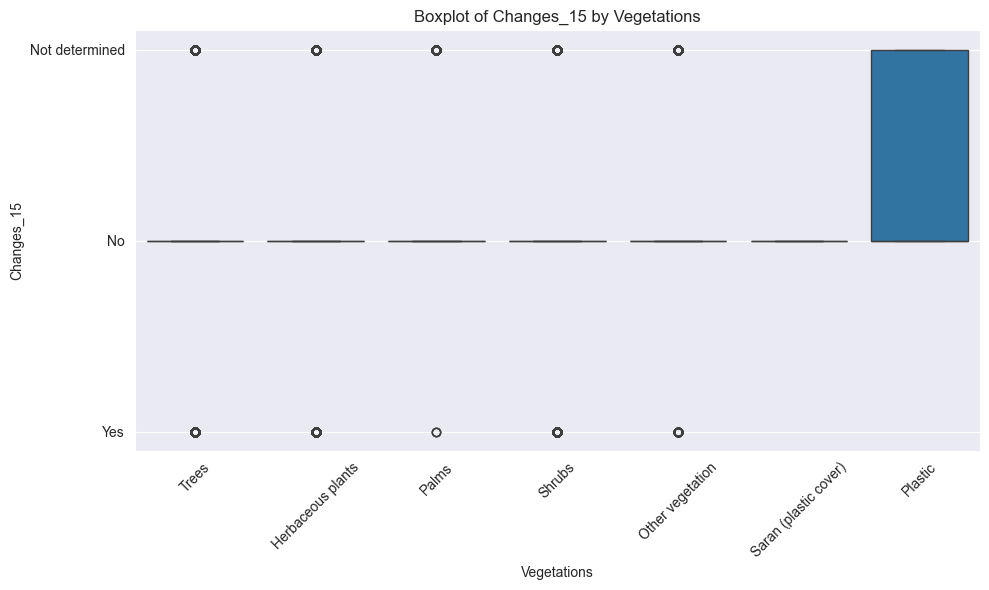

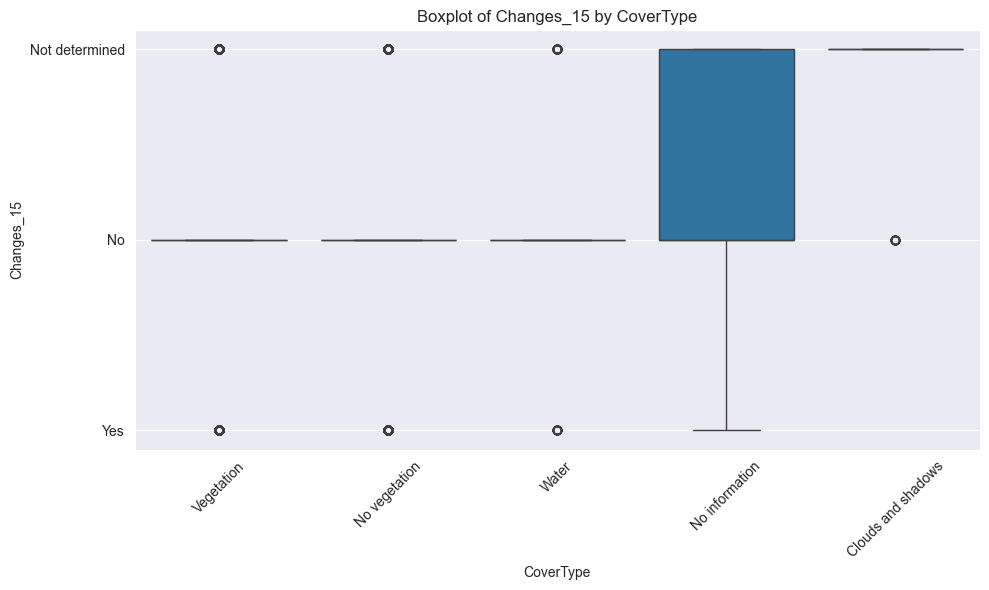

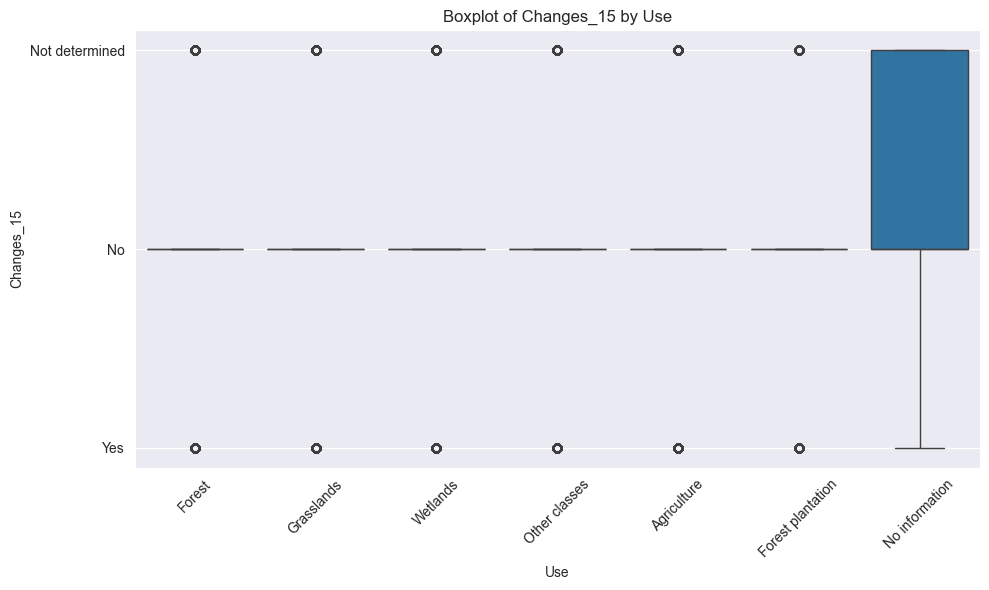

In [12]:
# creating a boxplot for Changes_15 based on Vegetations
plt.figure(figsize=(10, 6))
sb.boxplot(x='Vegetations', y='Changes_15', data=gdf_e)
plt.title('Boxplot of Changes_15 by Vegetations')
plt.xlabel('Vegetations')
plt.ylabel('Changes_15')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

# creating a boxplot for Changes_15 based on CoverType
plt.figure(figsize=(10, 6))
sb.boxplot(x='CoverType', y='Changes_15', data=gdf_e)
plt.title('Boxplot of Changes_15 by CoverType')
plt.xlabel('CoverType')
plt.ylabel('Changes_15')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# creating a boxplot for Changes_15 based on Use
plt.figure(figsize=(10, 6))
sb.boxplot(x='Use', y='Changes_15', data=gdf_e)
plt.title('Boxplot of Changes_15 by Use')
plt.xlabel('Use')
plt.ylabel('Changes_15')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Viewing all of the missing value counts for each predictor

In [13]:
# count missing values for each column
missing_values = gdf_e.isnull().sum()

# sort the result by the count of missing values (ascending by default)
sorted_missing_values = missing_values.sort_values(ascending = False)

# display the result
print("Missing values in each column (sorted):")
print(sorted_missing_values)
print(f'the total number of entries form the original geodataframe: {gdf_e.shape}')

Missing values in each column (sorted):
WaterBodyType     100273
Gain_Loss          97928
WetlandArea        97234
OtherClass         95711
LandType           95602
CropsType          92762
SAF                92762
GrasslandShrub     77869
Herbaceous         76695
Vegetations         7002
CoverType            216
Use                  216
Changes_15           216
plotid                 0
sampleid               0
geometry               0
dtype: int64
the total number of entries form the original geodataframe: (101160, 16)


### Uso's Null Values & Cobertura's 'Sin informacion'

In [14]:
# Creates a subset of the data that only contains columns that had null/empty values (from previous output)
# and the columns we are interested in (i.e. not Cambios15_ and Gana_Perdi)
subset_gdf = gdf[['Uso', 'Cobertura', 'Vegetacion', 'Herbaceas', 'Pasto_Arb', 'Cultivo', 'Humedal', 'Terreno', 'Agua', 'Otra_clase', 'SAF']]

# Search for the number of rows that contain all na values
na_rows=subset_gdf[subset_gdf.isna().all(axis=1)]
print('number of rows with all na =',na_rows.shape[0])

# Display the dataframe of the rows which contain all na values (for confirmation)
display(na_rows)

number of rows with all na = 216


,Uso,Cobertura,Vegetacion,Herbaceas,Pasto_Arb,Cultivo,Humedal,Terreno,Agua,Otra_clase,SAF
14112,None,None,None,None,None,None,None,None,None,None,None
14113,None,None,None,None,None,None,None,None,None,None,None
14114,None,None,None,None,None,None,None,None,None,None,None
14115,None,None,None,None,None,None,None,None,None,None,None
14116,None,None,None,None,None,None,None,None,None,None,None
14117,None,None,None,None,None,None,None,None,None,None,None
14118,None,None,None,None,None,None,None,None,None,None,None
14119,None,None,None,None,None,None,None,None,None,None,None
14120,None,None,None,None,None,None,None,None,None,None,None
35748,None,None,None,None,None,None,None,None,None,None,None


In [15]:
# Creates a subset of our 'subset_gdf' where Uso and Cobertura have the value 'Sin informacion'
# We do this because we want to check if these rows have any useful information (as 'Sin informacion' means no information)
filtered_rows = subset_gdf[subset_gdf['Uso'] == 'Sin informacion']
filtered_rows = filtered_rows[filtered_rows['Cobertura'] == 'Sin informacion']

# Creates a dictionary of the unique values of all the columns in filtered_rows
unique_values = {col: filtered_rows[col].unique().tolist() for col in filtered_rows.columns}

# Check the unique values of the columns in filtered_rows
pprint.pprint(unique_values, sort_dicts=False)
# Since the rest of the columns have no values, this shows us that these rows are not important to keep 

{'Uso': ['Sin informacion'],
 'Cobertura': ['Sin informacion'],
 'Vegetacion': [None],
 'Herbaceas': [None],
 'Pasto_Arb': [None],
 'Cultivo': [None],
 'Humedal': [None],
 'Terreno': [None],
 'Agua': [None],
 'Otra_clase': [None],
 'SAF': [None]}


In [16]:
# Create a subset of 'gdf' without the na_rows previously found
gdf_cleaned = gdf.drop(na_rows.index)

# Drops the rows from 'gdf_cleaned' that had 'Sin informacion' and null/empty values (i.e. filtered_rows)
gdf_cleaned = gdf_cleaned.drop(filtered_rows.index)

# Time to check the null presence and counts in each column
nulls_in_columns = gdf_cleaned.isna().any()
null_counts = gdf_cleaned.isna().sum()

# Print the results in a visually aligned format
print(f"{'Column':<20}{'Contains Nulls':<15}\t\t\t{'Null Count':<10}")
print("-" * 55)

for column in gdf_cleaned.columns:
    has_null = nulls_in_columns[column]
    null_count = null_counts[column]
    print(f"{column:<20}{str(has_null):<15}\t\t\t{null_count:<10}")
    
# Notice that now there are no nulls in 'Uso', 'Cobertura', and 'Cambios15_' (coincidentally).
# The next smallest null count is from 'Vegetacion', so that's what we're going to look at next.
# Furthermore, another reason why the 'Vegetacion' column is interesting is because it is used in every type of 'Uso'; meaning, it's supposed to be a must to fill-in.

Column              Contains Nulls 			Null Count
-------------------------------------------------------
Source.Nam          False          			0         
plotid              False          			0         
sampleid            False          			0         
lon                 False          			0         
lat                 False          			0         
sample_geo          False          			0         
Uso                 False          			0         
Cobertura           False          			0         
Vegetacion          True           			6685      
Herbaceas           True           			76378     
Pasto_Arb           True           			77552     
Cultivo             True           			92445     
Humedal             True           			96917     
Terreno             True           			95285     
Agua                True           			99956     
Otra_clase          True           			95394     
SAF                 True           			92445     
Cambios15_          False          			0         
Gana_Perdi   

### Looking into Vegetacion

In [17]:
# Creates a subset of the data that only contains columns that had null/empty values (from previous output) and the columns we are interested in
subset_gdf = gdf_cleaned[['Vegetacion', 'Herbaceas', 'Pasto_Arb', 'Cultivo', 'Humedal', 'Terreno', 'Agua', 'Otra_clase', 'SAF']]
sliced_gdf = gdf_cleaned[['Uso', 'Cobertura', 'Vegetacion', 'Herbaceas', 'Pasto_Arb', 'Cultivo', 'Humedal', 'Terreno', 'Agua', 'Otra_clase', 'SAF', 'Cambios15_', 'Gana_Perdi']]

# Search for the number of rows that contain all na values
na_rows=subset_gdf[subset_gdf.isna().all(axis=1)]
print('number of rows with all na =',na_rows.shape[0])
# Display the dataframe of the rows which contain all na values (for confirmation)
display(sliced_gdf.loc[na_rows.index])

# Creates a dictionary of the unique values of all the columns in filtered_rows
#unique_values = {col: sliced_gdf.loc[na_rows.index][col].unique().tolist() for col in sliced_gdf.loc[na_rows.index].columns}

# Check the unique values of the columns in filtered_rows
#pprint.pprint(unique_values, sort_dicts=False)

# Ask the question, should we be keeping these records in the dataframe?
# They provide no data outside of 'Uso' and 'Cobertura', and even then the data is limited to 'Sin informacion', 'Bosque', and 'Nubes y sombras'. 

number of rows with all na = 54


,Uso,Cobertura,Vegetacion,Herbaceas,Pasto_Arb,Cultivo,Humedal,Terreno,Agua,Otra_clase,SAF,Cambios15_,Gana_Perdi
12290,Bosque,Sin informacion,None,None,None,None,None,None,None,None,None,No,None
12291,Bosque,Sin informacion,None,None,None,None,None,None,None,None,None,No,None
12638,Sin informacion,Nubes y sombras,None,None,None,None,None,None,None,None,None,No se determina,None
12639,Sin informacion,Nubes y sombras,None,None,None,None,None,None,None,None,None,No se determina,None
12640,Sin informacion,Nubes y sombras,None,None,None,None,None,None,None,None,None,No se determina,None
12641,Sin informacion,Nubes y sombras,None,None,None,None,None,None,None,None,None,No se determina,None
12642,Sin informacion,Nubes y sombras,None,None,None,None,None,None,None,None,None,No se determina,None
12643,Sin informacion,Nubes y sombras,None,None,None,None,None,None,None,None,None,No se determina,None
12644,Sin informacion,Nubes y sombras,None,None,None,None,None,None,None,None,None,No se determina,None
12938,Sin informacion,Nubes y sombras,None,None,None,None,None,None,None,None,None,No,None


In [18]:
# Insert code here for Section 3

# WaterBodyType (Agua) Processing

### Imputing the rest of the features to perform Random Forest to predict and fill  WaterBodyType missing values 

In [19]:
# Libraries for the pre-processing pipeline v1 (basic imputation using mode (for categorical values))
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [20]:
# replace non-standard missing values with np.nan
gdf_e.replace(["None", None, ""], np.nan, inplace=True)

# exclude the geometry column for processing
gdf_e_non_geometry = gdf_e.drop(columns=["geometry"])

# define preprocessing pipeline
def create_preprocessing_pipeline():
    # Select categorical and numerical features, excluding 'WaterBodyType'
    categorical_features = gdf_e_non_geometry.select_dtypes(include=['object']).columns
    numerical_features = gdf_e_non_geometry.select_dtypes(include=['float64', 'int64']).columns

    # remove 'WaterBodyType' from the list of features to impute
    categorical_features = categorical_features[categorical_features != 'WaterBodyType']
    numerical_features = numerical_features[numerical_features != 'WaterBodyType']

    # create imputers for categorical and numerical features
    numerical_imputer = SimpleImputer(strategy='mean')
    categorical_imputer = SimpleImputer(strategy='most_frequent')

    # create column transformer to handle different feature types
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_imputer, numerical_features),
            ('cat', categorical_imputer, categorical_features)
        ]
    )

    return preprocessor

# create the preprocessing pipeline
preprocessor = create_preprocessing_pipeline()

# apply the preprocessing pipeline to the non-geometry data
geo_df_preprocessed = preprocessor.fit_transform(gdf_e_non_geometry)

# check the number of columns in the preprocessed data
print("Number of columns in preprocessed data:", geo_df_preprocessed.shape[1])

# convert the preprocessed data back into a DataFrame with correct column names
processed_df = pd.DataFrame(
    geo_df_preprocessed,
    columns=gdf_e_non_geometry.drop(columns=['WaterBodyType']).columns  # Exclude 'WaterBodyType' from columns
)

# reattach the original 'WaterBodyType' column (non-imputed)
processed_df["WaterBodyType"] = gdf_e["WaterBodyType"].values

# reattach the geometry column
processed_df["geometry"] = gdf_e["geometry"].values

# save the processed DataFrame to a new variable
imputer_gdf_e = processed_df.copy()

# validate the output
print("Missing values after processing:")
processed_missing_check = imputer_gdf_e.isnull().sum()
sorted_processed_missings = processed_missing_check.sort_values(ascending=False)
print(sorted_processed_missings)

# print the first 5 rows of the original and processed DataFrames for comparison
print("Original DataFrame (First 5 rows):")
print(gdf_e.head())

print("**************************************************************************")
print("\nProcessed DataFrame (First 5 rows):")
print(imputer_gdf_e.head())

Number of columns in preprocessed data: 14
Missing values after processing:
WaterBodyType     100273
plotid                 0
Use                    0
sampleid               0
Vegetations            0
Herbaceous             0
GrasslandShrub         0
CoverType              0
CropsType              0
WetlandArea            0
OtherClass             0
LandType               0
SAF                    0
Changes_15             0
Gain_Loss              0
geometry               0
dtype: int64
Original DataFrame (First 5 rows):
   plotid  sampleid         Use   CoverType        Vegetations Herbaceous  \
0    2900     11597      Forest  Vegetation              Trees        NaN   
1    2900     11598  Grasslands  Vegetation  Herbaceous plants    Grasses   
2    2900     11599  Grasslands  Vegetation  Herbaceous plants    Grasses   
3    2900     11600      Forest  Vegetation              Trees        NaN   
4    2900     11601      Forest  Vegetation              Trees        NaN   

           Gr

What I have done here is impute the remaining categorical/object-type features with their mode (the most frequent value) to address the missing data. While this approach is not the most efficient, I believe we could achieve better results by focusing on our main feature of interest and imputing data using a smaller subset of the gdf, specifically leveraging highly correlated features. This strategy could potentially address the larger issue of the high number of missing values in the water source data more effectively.

Verifying if the values for the rest of the features were imputed

In [21]:
print(imputer_gdf_e.isnull().sum())  # Check if there are any missing values
imputer_gdf_e.shape

plotid                 0
sampleid               0
Use                    0
CoverType              0
Vegetations            0
Herbaceous             0
GrasslandShrub         0
CropsType              0
WetlandArea            0
LandType               0
OtherClass             0
SAF                    0
Changes_15             0
Gain_Loss              0
WaterBodyType     100273
geometry               0
dtype: int64


(101160, 16)

It looks like they were indeed imputed

### Creating a Random Forest imputer function 

In [22]:
# libaries for the random forest function imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [23]:
# Step 1: Handle missing values in 'WaterBodyType' if needed
imputer_gdf_e['WaterBodyType'] = imputer_gdf_e['WaterBodyType'].fillna('Unknown')

# Step 2: Identify categorical columns (non-numeric, excluding 'WaterBodyType')
categorical_columns = imputer_gdf_e.select_dtypes(include=['object']).columns

# Step 3: Encode categorical columns
label_encoders = {}
for col in categorical_columns:
    if col != 'WaterBodyType':  # Make sure not to encode the target column
        le = LabelEncoder()
        imputer_gdf_e[col] = le.fit_transform(imputer_gdf_e[col])
        label_encoders[col] = le  # Store the encoder for future inverse_transform if needed

# Step 4: Encode the target column 'WaterBodyType'
target_encoder = LabelEncoder()
imputer_gdf_e['WaterBodyType'] = target_encoder.fit_transform(imputer_gdf_e['WaterBodyType'])

# Step 5: Split the data into features (X) and target (y)
X = imputer_gdf_e.drop(columns=['WaterBodyType'])  # Drop the target column from the features
y = imputer_gdf_e['WaterBodyType']  # Target column

# Step 6: Remove any non-numeric columns from the feature set (including 'geometry' or other object types)
X = X.select_dtypes(include=['number'])  # Only keep numeric columns in X

# Step 7: Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 8: Train Random Forest model
rf_imputer = RandomForestClassifier(n_estimators=100, random_state=42)
rf_imputer.fit(X_train, y_train)

# Step 9: Predict missing 'WaterBodyType' values
waterbody_type_imputed = rf_imputer.predict(X_test)

# Step 10: Optionally, inverse transform to get the original 'WaterBodyType' labels
waterbody_type_imputed_labels = target_encoder.inverse_transform(waterbody_type_imputed)

# Convert predictions to a pandas Series with the same index as X_test
predicted_waterbody_type = pd.Series(
    target_encoder.inverse_transform(waterbody_type_imputed),
    index=X_test.index,
    name='PredictedWaterBodyType'
)

# concatenate the predictions with the original GeoDataFrame
imputer_gdf_e_with_predictions = pd.concat([imputer_gdf_e, predicted_waterbody_type], axis=1)

# Step 11: Revert encoded categorical columns to original string values
for col, le in label_encoders.items():
    imputer_gdf_e_with_predictions[col] = le.inverse_transform(imputer_gdf_e_with_predictions[col])

# revert the target column (WaterBodyType) back to its original form
imputer_gdf_e_with_predictions['WaterBodyType'] = target_encoder.inverse_transform(imputer_gdf_e_with_predictions['WaterBodyType'])

# print the head of the updated GeoDataFrame
print(imputer_gdf_e_with_predictions.head())


   plotid sampleid         Use   CoverType        Vegetations Herbaceous  \
0  2900.0  11597.0      Forest  Vegetation              Trees    Grasses   
1  2900.0  11598.0  Grasslands  Vegetation  Herbaceous plants    Grasses   
2  2900.0  11599.0  Grasslands  Vegetation  Herbaceous plants    Grasses   
3  2900.0  11600.0      Forest  Vegetation              Trees    Grasses   
4  2900.0  11601.0      Forest  Vegetation              Trees    Grasses   

           GrasslandShrub CropsType    WetlandArea        LandType OtherClass  \
0  Mixed Pasture (70-90%)     Other  Swamp (Marsh)  Other surfaces  Bare Land   
1  Mixed Pasture (70-90%)     Other  Swamp (Marsh)  Other surfaces  Bare Land   
2  Mixed Pasture (70-90%)     Other  Swamp (Marsh)  Other surfaces  Bare Land   
3  Mixed Pasture (70-90%)     Other  Swamp (Marsh)  Other surfaces  Bare Land   
4  Mixed Pasture (70-90%)     Other  Swamp (Marsh)  Other surfaces  Bare Land   

                   SAF      Changes_15    Gain_Loss Wate

In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Step 1: Make predictions on the test set
y_pred = rf_imputer.predict(X_test)

# Step 2: Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Step 3: Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Step 4: Generate a classification report
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(class_report)

Accuracy: 0.9999

Confusion Matrix:
[[  159     2     0]
 [    0     8     0]
 [    0     0 20063]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       161
           1       0.80      1.00      0.89         8
           2       1.00      1.00      1.00     20063

    accuracy                           1.00     20232
   macro avg       0.93      1.00      0.96     20232
weighted avg       1.00      1.00      1.00     20232



In [25]:
# checking for missing values in the gdf
water_null = imputer_gdf_e_with_predictions.isnull().sum()

sorted_water_null = water_null.sort_values(ascending = False)

print(sorted_water_null)

PredictedWaterBodyType    80928
plotid                        0
sampleid                      0
CoverType                     0
Use                           0
Herbaceous                    0
GrasslandShrub                0
CropsType                     0
Vegetations                   0
WetlandArea                   0
LandType                      0
SAF                           0
OtherClass                    0
Changes_15                    0
Gain_Loss                     0
WaterBodyType                 0
geometry                      0
dtype: int64


Verifying how different is it from the original gdf

In [26]:
# looking at the original gdf with previous missing values 
original_null_count = gdf_e.isnull().sum()
sorted_orginal_null_count = original_null_count.sort_values(ascending = False)
print(sorted_orginal_null_count)

WaterBodyType     100273
Gain_Loss          97928
WetlandArea        97234
OtherClass         95711
LandType           95602
CropsType          92762
SAF                92762
GrasslandShrub     77869
Herbaceous         76695
Vegetations         7002
CoverType            216
Use                  216
Changes_15           216
plotid                 0
sampleid               0
geometry               0
dtype: int64


In [27]:
print(f'The Random Forest application dropped the number of missing values of WaterBodyType by {((100273-80928)/100273) * 100}%')

The Random Forest application dropped the number of missing values of WaterBodyType by 19.29233193382067%


In [35]:
display(imputer_gdf_e_with_predictions.head())
display(gdf_e.head())

,plotid,sampleid,Use,CoverType,Vegetations,Herbaceous,GrasslandShrub,CropsType,WetlandArea,LandType,OtherClass,SAF,Changes_15,Gain_Loss,WaterBodyType,geometry,PredictedWaterBodyType
0,2900.0,11597.0,Forest,Vegetation,Trees,Grasses,Mixed Pasture (70-90%),Other,Swamp (Marsh),Other surfaces,Bare Land,Pure crop (90-100%),Not determined,Forest loss,Unknown,POINT (-84.90887 10.87476),NaN
1,2900.0,11598.0,Grasslands,Vegetation,Herbaceous plants,Grasses,Mixed Pasture (70-90%),Other,Swamp (Marsh),Other surfaces,Bare Land,Pure crop (90-100%),Not determined,Forest loss,Unknown,POINT (-84.90887 10.87519),NaN
2,2900.0,11599.0,Grasslands,Vegetation,Herbaceous plants,Grasses,Mixed Pasture (70-90%),Other,Swamp (Marsh),Other surfaces,Bare Land,Pure crop (90-100%),Not determined,Forest loss,Unknown,POINT (-84.90887 10.87561),NaN
3,2900.0,11600.0,Forest,Vegetation,Trees,Grasses,Mixed Pasture (70-90%),Other,Swamp (Marsh),Other surfaces,Bare Land,Pure crop (90-100%),Not determined,Forest loss,Unknown,POINT (-84.90844 10.87476),NaN
4,2900.0,11601.0,Forest,Vegetation,Trees,Grasses,Mixed Pasture (70-90%),Other,Swamp (Marsh),Other surfaces,Bare Land,Pure crop (90-100%),Not determined,Forest loss,Unknown,POINT (-84.90844 10.87519),NaN


,plotid,sampleid,Use,CoverType,Vegetations,Herbaceous,GrasslandShrub,CropsType,WetlandArea,LandType,WaterBodyType,OtherClass,SAF,Changes_15,Gain_Loss,geometry
0,2900,11597,Forest,Vegetation,Trees,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not determined,NaN,POINT (-84.90887 10.87476)
1,2900,11598,Grasslands,Vegetation,Herbaceous plants,Grasses,Mixed Pasture (70-90%),NaN,NaN,NaN,NaN,NaN,NaN,Not determined,NaN,POINT (-84.90887 10.87519)
2,2900,11599,Grasslands,Vegetation,Herbaceous plants,Grasses,Mixed Pasture (70-90%),NaN,NaN,NaN,NaN,NaN,NaN,Not determined,NaN,POINT (-84.90887 10.87561)
3,2900,11600,Forest,Vegetation,Trees,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not determined,NaN,POINT (-84.90844 10.87476)
4,2900,11601,Forest,Vegetation,Trees,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not determined,NaN,POINT (-84.90844 10.87519)


## Section 4: Extract Medoid and NEM Data
### Forewarning

The following two sections will take at least an hour to run, and will require setting up a Google Earth Engine project within your Google Drive.
Therefore, if you'd prefer to skip this section, please uncomment the code below, run it, and skip to Section 6.

In [28]:
# Insert code here that imports a saved GeoDataFrame with Medoid, NEM, and Predictor Data

TODO: Add comments about what the cell above does

In [29]:
# Insert code here from John's notebook on Medoid and NEM Data

## Section 5: Create and Extract Predictor Surfaces
### {subheading}

In [30]:
# Insert code here from John's notebook on Predictor Values and Surfaces

## Section 6: Clean Remote Sensing Data
### {subheading}

In [31]:
# Insert code here that cleans the Remote Sensing Data and discusses any observations

## Section 7: Preprocessing
### {subheading}

In [32]:
# Insert code here that prepares the data for modeling

## Section 8: Build a Predictive Model
### {subheading}

In [33]:
# Insert code here that builds the Predictive Model